<a href="https://colab.research.google.com/github/k94y/pytorch/blob/main/pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training log: 1 epoch (128 / 60000 train. data). Loss: 2.304140329360962
Training log: 1 epoch (1408 / 60000 train. data). Loss: 1.4543596506118774
Training log: 1 epoch (2688 / 60000 train. data). Loss: 0.9621217846870422
Training log: 1 epoch (3968 / 60000 train. data). Loss: 0.8998009562492371
Training log: 1 epoch (5248 / 60000 train. data). Loss: 0.958156943321228
Training log: 1 epoch (6528 / 60000 train. data). Loss: 0.6204862594604492
Training log: 1 epoch (7808 / 60000 train. data). Loss: 0.5795583128929138
Training log: 1 epoch (9088 / 60000 train. data). Loss: 0.6549996137619019
Training log: 1 epoch (10368 / 60000 train. data). Loss: 0.510727047920227
Training log: 1 epoch (11648 / 60000 train. data). Loss: 0.5998439788818359
Training log: 1 epoch (12928 / 60000 train. data). Loss: 0.76120924949646
Training log: 1 epoch (14208 / 60000 train. data). Loss: 0.4946843683719635
Training log: 1 epoch (15488 / 60000 train. data). Loss: 0.7610865235328674
Training log: 1 epoch (167

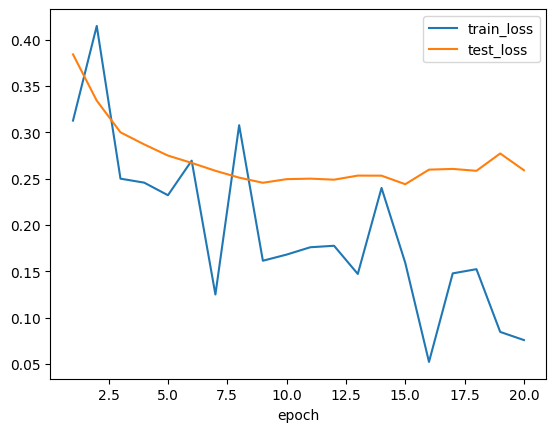

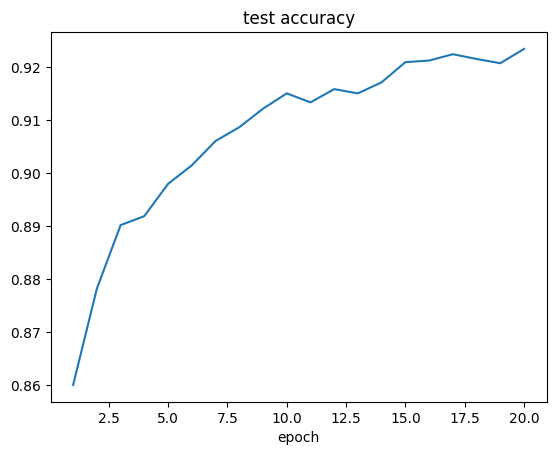

In [42]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.relu = torch.nn.ReLU()
        self.silu = torch.nn.SiLU()
        self.padding = torch.nn.ZeroPad2d(1)
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        self.conv1 = torch.nn.Conv2d(1,16,3)
        self.dropout = torch.nn.Dropout(0.25)
        self.fc1 = torch.nn.Linear(16 * 14 * 14, 400)
        self.fc2 = torch.nn.Linear(400, 100)
        self.fc3 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.padding(x)
        x = self.conv1(x)
        x = self.silu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return f.log_softmax(x, dim=1)


def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)

    return {'train': train_loader, 'test': test_loader}


if __name__ == '__main__':
    # 学習回数
    epoch = 20

    # 学習結果の保存用
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
    }

    # ネットワークを構築
    device = torch.device("cuda:0")
    net: torch.nn.Module = MyNet()
    net.to(device)

    # MNISTのデータローダーを取得
    loaders = load_MNIST()

    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    for e in range(epoch):

        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
        for i, (data, target) in enumerate(loaders['train']):
            # 全結合のみのネットワークでは入力を1次元に
            # print(data.shape)  # torch.Size([128, 1, 28, 28])
            # data = data.view(-1, 28*28)
            # print(data.shape)  # torch.Size([128, 784])

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = f.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(e+1,
                                                                                         (i+1)*128,
                                                                                         loss.item())
                      )

        history['train_loss'].append(loss)

        """ Test Part """
        # 学習のストップ
        net.eval()  # または net.train(False) でも良い
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in loaders['test']:
                data, target = data.to(device), target.to(device)
                output = net(data)
                test_loss += f.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= 10000

        print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                         correct / 10000))

        history['test_loss'].append(test_loss)
        history['test_acc'].append(correct / 10000)

    # 結果の出力と描画
    print(history)
    history['train_loss'] = list(map(lambda x: x.detach().cpu(), history['train_loss']))
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'], label='train_loss')
    plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig('loss.png')

    plt.figure()
    plt.plot(range(1, epoch+1), history['test_acc'])
    plt.title('test accuracy')
    plt.xlabel('epoch')
    plt.savefig('test_acc.png')